In [2]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm

# Plot settings
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
%matplotlib inline
%config InlineBackend.figure_format='retina'


In [3]:
G=1

# Myiamoto-Nagai Disk

## Mass of the galaxy from the mass of the halo
Moster et all provides an empirical relation: $\dfrac{M_{star}}{M_{halo}} = 2N \left[\left(\dfrac{M_{halo}}{M_1}\right)^{-\beta} + \left(\dfrac{M_{halo}}{M_1}\right)^\gamma\right]^{-1}$, where $N$, $M_1$, $\beta$ and $\gamma$ are just parameters whose estimates can be found in the paper.

In [4]:
def M_1(z):
    M_10 = 11.590
    M_11 = 1.195
    return 10 ** (M_10 + M_11 * z / (z + 1))

def N_(z):
    N_10 = 0.0351
    N_11 = -0.0247
    return N_10 + N_11 * z / (z + 1)

def beta(z):
    beta_10 = 1.376
    beta_11 = -0.826
    return beta_10 + beta_11 * z / (z + 1)

def gamma(z):
    gamma_10 = 0.608
    gamma_11 = 0.329
    return gamma_10 + gamma_11 * z / (z + 1)

def m_star_m_halo(M, z=0):
    a = (M / M_1(z)) ** (-beta(z))
    b = (M / M_1(z)) ** (gamma(z))
    return 2 * M * N_(z) / (a + b)

In [5]:
#stiamo facendo tutto in int units considerando G=1 e massa in masse solari e raggi in kpc
num_particles = 20000

M_H_sun = 10**12
M_D_sun = m_star_m_halo(M_H_sun)

print(f'Mass Disk {M_D_sun:.2e}')

Mass Disk 3.43e+10


In [6]:
#proportion to rescale the masses in internal units

M_H = 1000
M_D = M_H * M_D_sun / M_H_sun

print(f'Mass Disk (int units){M_D:.5e}')

m_particles = float(M_D/num_particles)

Mass Disk (int units)3.42752e+01


## Positions Myiamoto - Nagai Disk

In [7]:
const = 1.0
a = 3
b = 0.05 * a

R_max = 30  # kpc
z_max = 5  # esempio di limite massimo per z

a_H = 6

In [8]:
def rho_D(R, z):
    ''' Densità volumica di Miyamoto-Nagai  '''
    sqrt_zb = np.sqrt(z**2 + b**2)
    numerator = b**2 * M_D * (a * R**2 + (a + 3 * sqrt_zb) * (a + sqrt_zb)**2)
    denominator = 4 * np.pi * (R**2 + (a + sqrt_zb)**2)**(5/2) * (z**2 + b**2)**(3/2)
    return numerator / denominator


In [9]:
# Lettura del file .npy
loaded_coordinates = np.load("../coord_MCMC_20k.npy")
x_particles, y_particles, z_particles, R_particles, phi_particles = loaded_coordinates

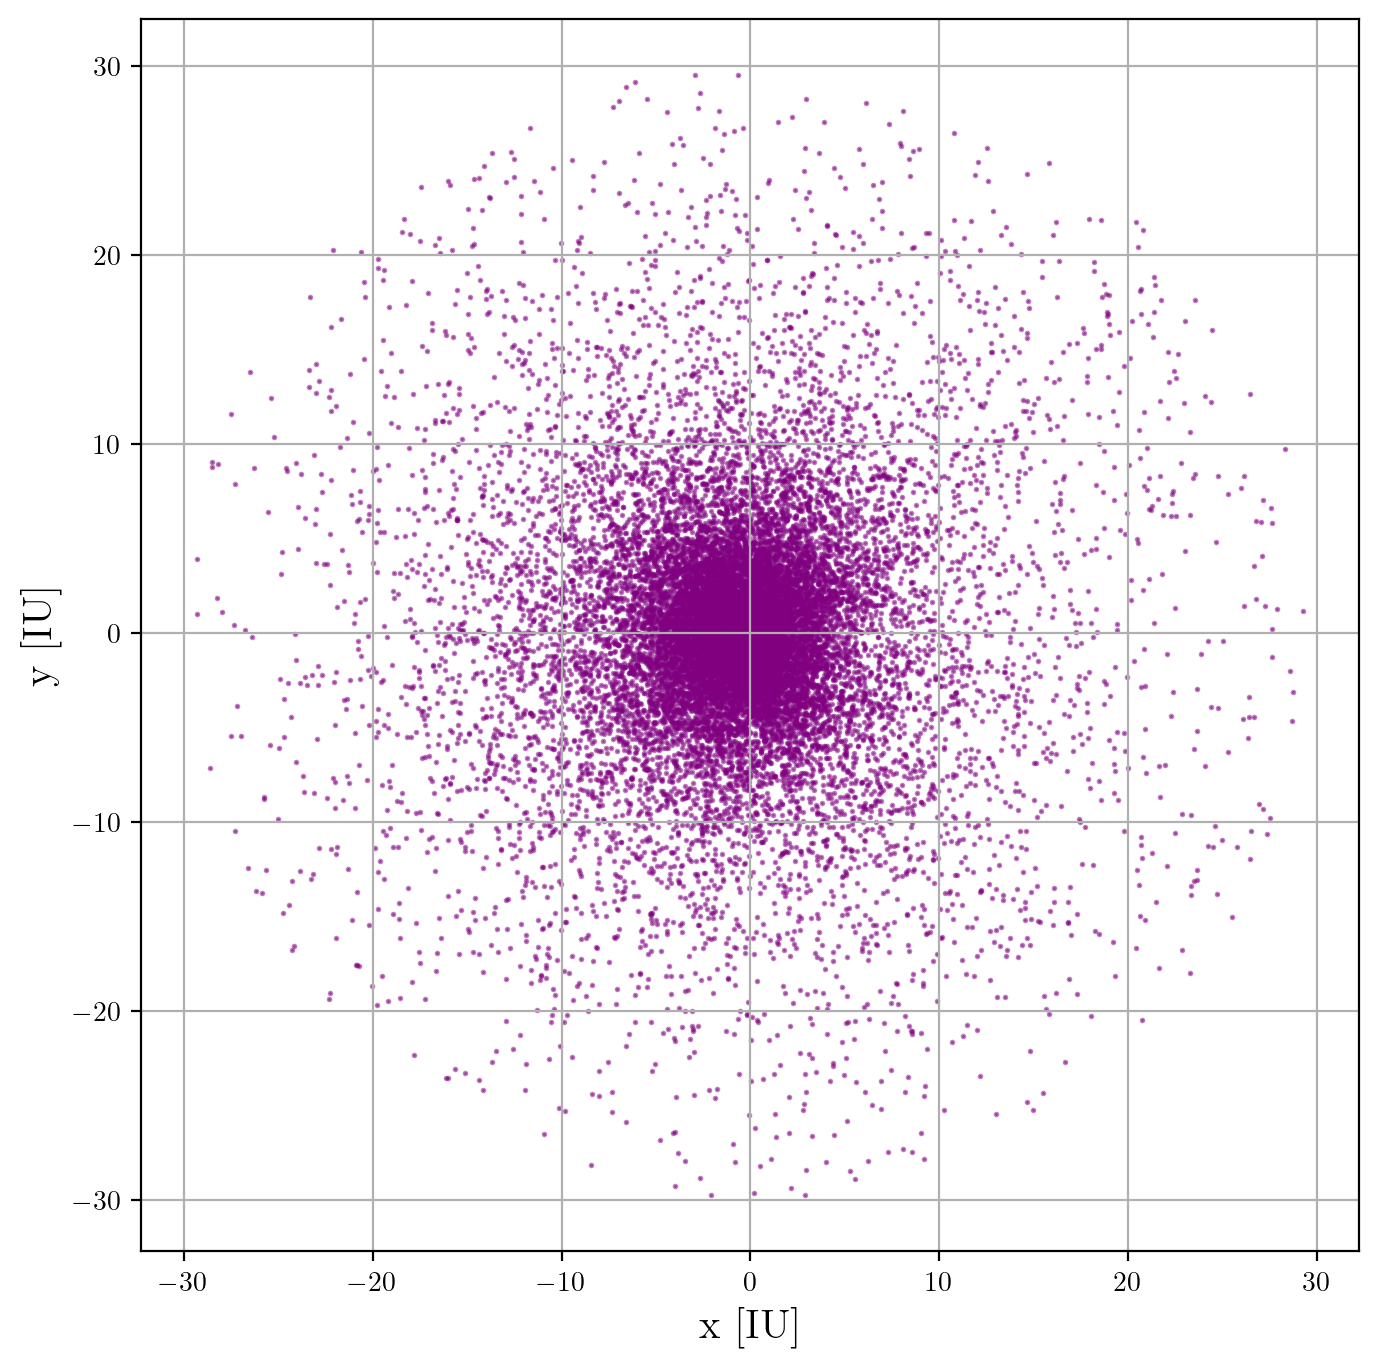

In [10]:
plt.figure(figsize=(8, 8))
plt.scatter(x_particles, y_particles, s=1, color='purple', alpha=0.5)
plt.xlabel("x [IU]", fontsize=15)
plt.ylabel("y [IU]", fontsize=15)
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True)
plt.savefig('xy_plane.png')
plt.show()


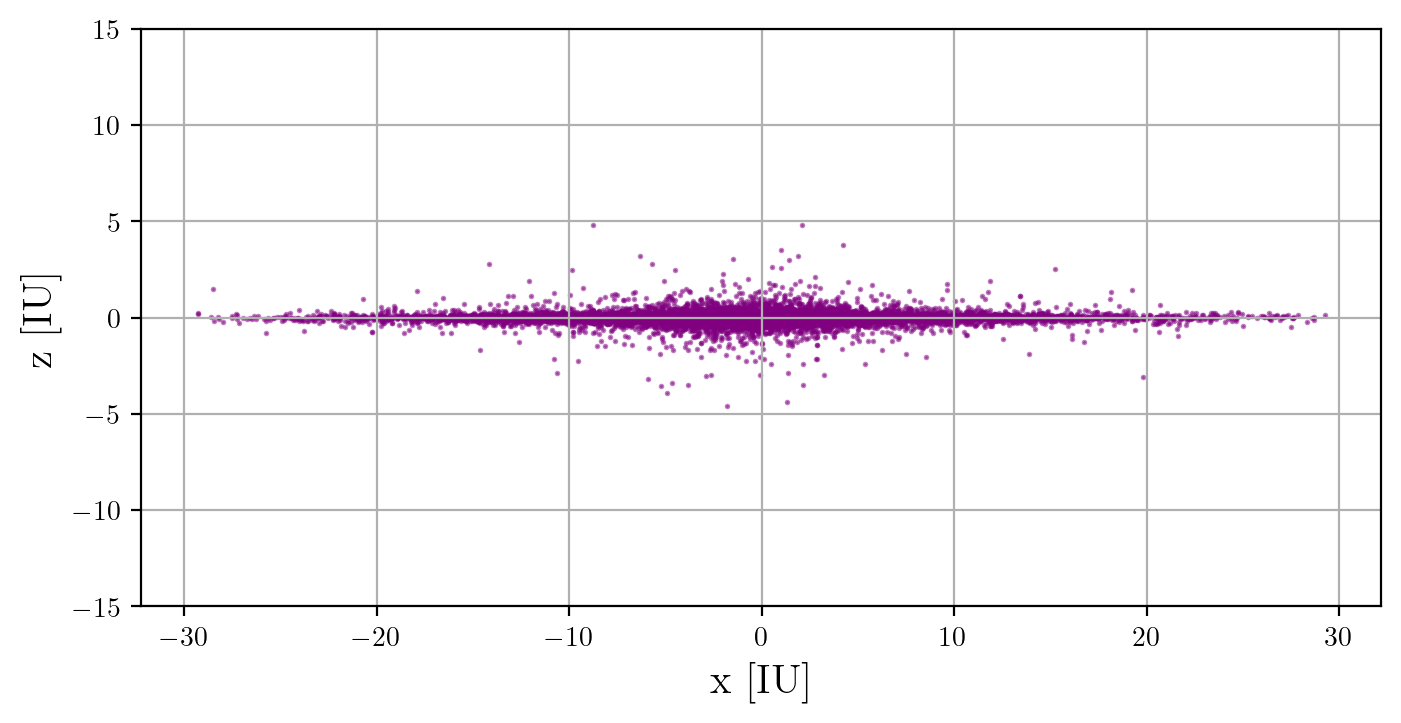

In [11]:
plt.figure(figsize=(8, 8))
plt.scatter(x_particles, z_particles, s=1, color='purple', alpha=0.5)
#plt.title("Distribuzione delle particelle nel piano xy")
plt.xlabel("x [IU]", fontsize=15)
plt.ylabel("z [IU]", fontsize=15)
plt.gca().set_aspect('equal', adjustable='box')  # Mantieni le proporzioni uguali per x e y
plt.grid(True)
plt.ylim(-15,15)
plt.savefig('xz_plane.png')
plt.show()


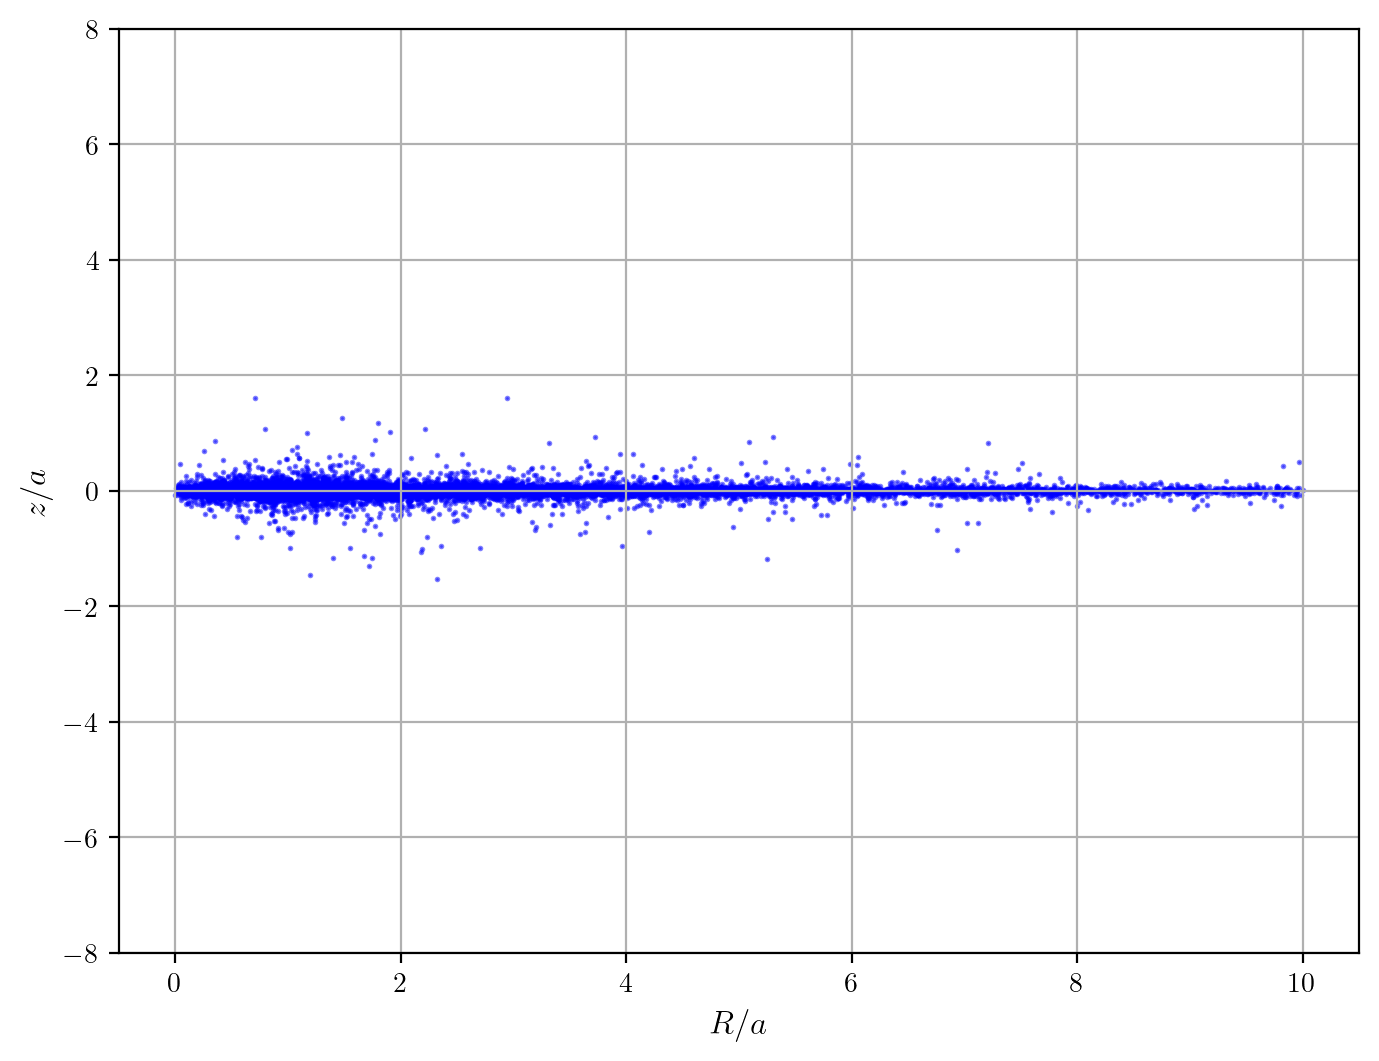

In [12]:
plt.figure(figsize=(8, 6))
plt.scatter(np.array(R_particles) / a, np.array(z_particles) / a, s=1, color='blue', alpha=0.5)
plt.xlabel('$R/a$', fontsize=12)
plt.ylabel('$z/a$', fontsize=12)
plt.grid(True)
plt.ylim(-8,8)
plt.show()

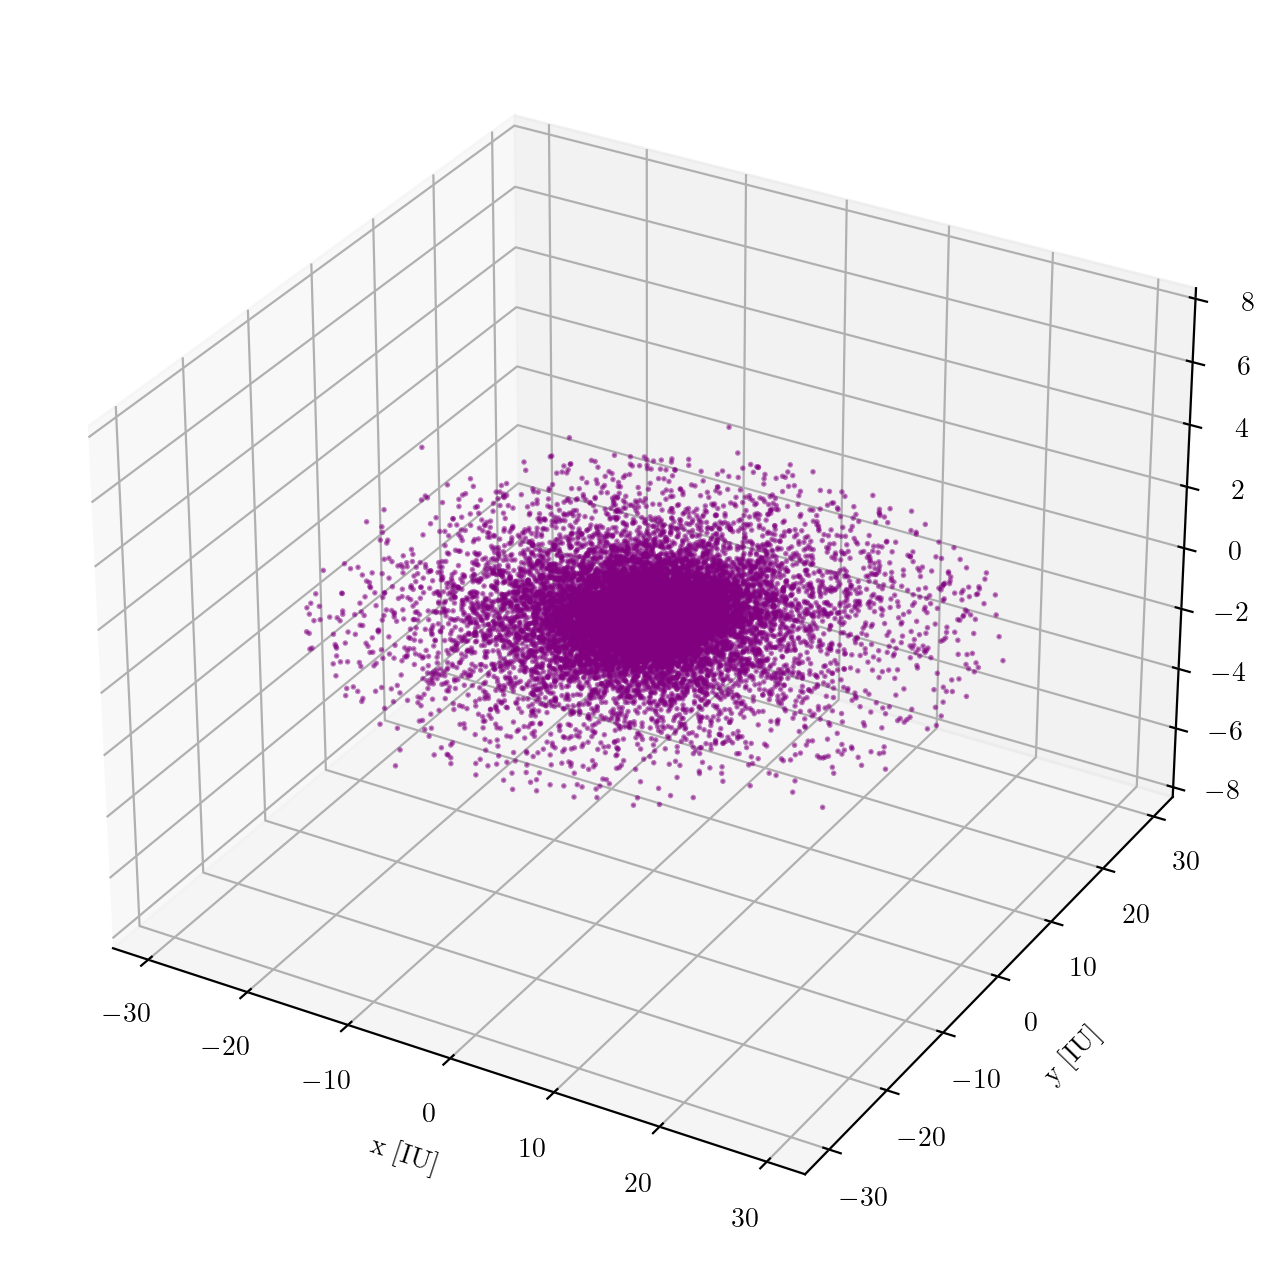

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Plot delle posizioni delle particelle in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot delle particelle
ax.scatter(x_particles, y_particles, z_particles, s=1, color='purple', alpha=0.5)

# Titoli e etichette
#ax.set_title("Distribuzione delle particelle nello spazio 3D")
ax.set_xlabel("x [IU]")
ax.set_ylabel("y [IU]")
ax.set_zlabel("z [IU]")
ax.set_zlim(-8,8)

# Mostra il grafico
plt.savefig('3d_particles.png')
plt.show()


## Velocities

### Potenziale dell'alone:
$$
\Phi_{\text{halo}}(R, z) = - \frac{G M_H}{\sqrt{R^2 + z^2} + a_H}
$$

### Potenziale del disco:
$$
\Phi_{\text{disk}}(R, z) = - \frac{G M_D}{\sqrt{\left(a_D + \sqrt{z^2 + b^2}\right)^2 + R^2}}
$$

### Derivata del potenziale rispetto a \(R\) per la velocità circolare (z=0):
$$
\frac{\partial \Phi}{\partial R} =\frac{\partial (\Phi_{\text{disk}}+\Phi_{\text{halo}})}{\partial R} = G R \left( M_D \left[\left(a_D + b\right)^2 + R^2\right]^{-\frac{3}{2}} + M_H \frac{1}{\left(R + A\right)^2 R} \right)
$$

### Velocità circolare:
$$
v_{\text{circ}}(R) = \sqrt{R \cdot \frac{\partial \Phi}{\partial R}}
$$

### Distribuzione di v_z

$$
f(v_z) = \frac{1}{\sqrt{2\pi} \sigma_z} \exp\left(-\frac{v_z^2}{2\sigma_z^2}\right)
$$

### Rho Halo, Hernquist
$$
\rho(R, z) = \frac{M}{2\pi} \frac{a}{\sqrt{R^2 + z^2} \left(\sqrt{R^2 + z^2} + a\right)^3}
$$



### Densità di Miyamoto-Nagai
$$
\rho(R, z) = \frac{b^2 M}{4 \pi} \frac{a R^2 + (a + 3\sqrt{z^2 + b^2})(a + \sqrt{z^2 + b^2})^2}{\left[R^2 + (a + \sqrt{z^2 + b^2})^2\right]^{5/2}(z^2 + b^2)^{3/2}}
$$

In [17]:


def M_encl (r):
    return M_H * (r**2 / (r+ a_H)**2)

def pot_halo (R,z):
    r = np.sqrt(R**2 + z**2)
    #M_encl = M_H * (r**2 / (r+ a_H)**2)
    M_H_enclosed = M_encl (r)
    return - G * M_H_enclosed / (r)

def pot_disk (R,z):
    return - G * M_D / np.sqrt((a+np.sqrt(z**2. + b**2.))**2. + R**2.)
'''
def dphi_dr(R):
    # Derivata prima del potenziale totale (halo + disk) a z=0
    M_H_enclosed = M_H * (R**2 / (R + a_H)**2)  # Enclosed halo mass
    halo_term = G * M_H_enclosed / R**2
    disk_term = G * M_D * R * ((a + b)**2 + R**2)**(-3./2.)
    return halo_term + disk_term'''

'''
def second_dphi_dr(R):
    #Derivata seconda del potenziale totale (halo + disk) a z=0
    M_H_enclosed = M_H * (R**2 / (R + a_H)**2)
    halo_term = G * (M_H_enclosed / R**3 - 2 * M_H / (R + a_H)**3)
    disk_term = G * M_D * ((a + b)**2 - 2 * R**2) * ((a + b)**2 + R**2)**(-5./2.)
    return halo_term + disk_term'''

def dphi_dr (R):
    ''' derivata prima del potenziale totale (halo + disk) a z=0'''
    return G * R * (M_D * ((a + b)**2. + R**2)**(-3./2.) + M_H * (R+a_H)**(-2) * R**(-1))

def second_dphi_dr (R):
    ''' derivata seconda del potenziale totale (halo + disk) a z=0'''
    return dphi_dr(R)/R + G * R * (M_D*(-3*R*((a+b)**2 + R**2)**(-5/2)) - M_H * (2 * (R+a_H)**(-3) * R**(-1) + (R+a_H)**(-2) * R**(-2)))
    

def v_circ(R):
    return np.sqrt(dphi_dr(R) * R)

def omega(R):
    return np.sqrt(dphi_dr(R)/R)

def kappa(R):
    return np.sqrt(second_dphi_dr(R) + 3 * dphi_dr(R)/R)

def rho_H(R, z):
    ''' Densità volumica di hernquist  '''
    return (M_H / (2 * np.pi)) * (a / (np.sqrt(R**2 + z**2) * (np.sqrt(R**2 + z**2) + a)**3))

def rho_tot(R,z):
    return rho_D(R,z) + rho_H(R,z)
'''
def sigma_r(R, Q=1.2):
    S = Sigma(R)
    k = kappa(R)
    return 3.36 * Q * G * S / k'''

def sigma_z(R_values, b=b):
    print('b=',b)
    surface_density = Sigma(R_values)
    return np.sqrt(np.pi * G * surface_density * b / 2)

def compute_Q (R, b=b):
    k = kappa(R)
    S = Sigma(R)
    print('b=',b)
    return k/3.36 * np.sqrt((np.pi*b)/(G*S*2))

def Sigma(R_values):
    ''' Calcola la densità superficiale per ogni R dato'''
    # Preallocazione dell'array per i risultati
    Sigma_values = np.zeros_like(R_values)
    
    # Calcola l'integrale per ciascun valore di R
    for i, R in enumerate(R_values):
        Sigma_values[i] = 2 * np.trapz([rho_D(R, z) for z in np.linspace(0, z_max, 100)], dx=float(z_max/100))
    
    return Sigma_values

In [18]:
#compute Q given the b we have = 0.05
Q_values = compute_Q(R_particles)

b= 0.15000000000000002


In [19]:
print('Make sure that the minimum Q found is more than 1 \nMinimum Q = ',min(Q_values))

Make sure that the minimum Q found is more than 1 
Minimum Q =  1.0200143330500193


 #### ADD PERTURBER

In [17]:
#choose z,R,phi
z_pert = [np.mean(z_particles)]
R_pert = [5.2]
phi_pert = [np.pi/3.]
#compute z,y
x_pert = [R_pert[0] * np.cos(phi_pert[0])]
y_pert = [R_pert[0] * np.sin(phi_pert[0])]

m_pert = m_particles*500

x_tot = np.concatenate([x_pert, x_particles])
y_tot = np.concatenate([y_pert, y_particles])
z_tot = np.concatenate([z_pert, z_particles])

phi_tot = np.concatenate([phi_pert, phi_particles])
R_tot = np.concatenate([R_pert, R_particles])

print(x_tot.shape,y_tot.shape,z_tot.shape,R_tot.shape,phi_tot.shape)

(20001,) (20001,) (20001,) (20001,) (20001,)


In [18]:
m_pert

0.856878796401666

In [19]:
sig_r = sigma_z(np.array(R_tot))
sig_z = np.copy(sig_r)

b= 0.15000000000000002


In [20]:
v_r = sig_r * np.random.normal(size=num_particles+1)
v_phi =  v_circ(np.array(R_tot)) + sig_r * np.random.normal(size=num_particles+1)
v_phi[0] =  v_circ(np.array(R_tot[0])) #i am forcing the perturber to have the exact circular vel

v_x = -v_phi * np.sin(phi_tot) + v_r * np.cos(phi_tot)
v_y = v_phi * np.cos(phi_tot) + v_r * np.sin(phi_tot) 
v_z = sig_z * np.random.normal(size=num_particles+1)

print(f"Shape of v_r: {v_r.shape}")
print(f"Shape of v_phi: {v_phi.shape}")
print(f"Shape of v_x: {v_x.shape}")
print(f"Shape of v_y: {v_y.shape}")
print(f"Shape of v_z: {v_z.shape}")

Shape of v_r: (20001,)
Shape of v_phi: (20001,)
Shape of v_x: (20001,)
Shape of v_y: (20001,)
Shape of v_z: (20001,)


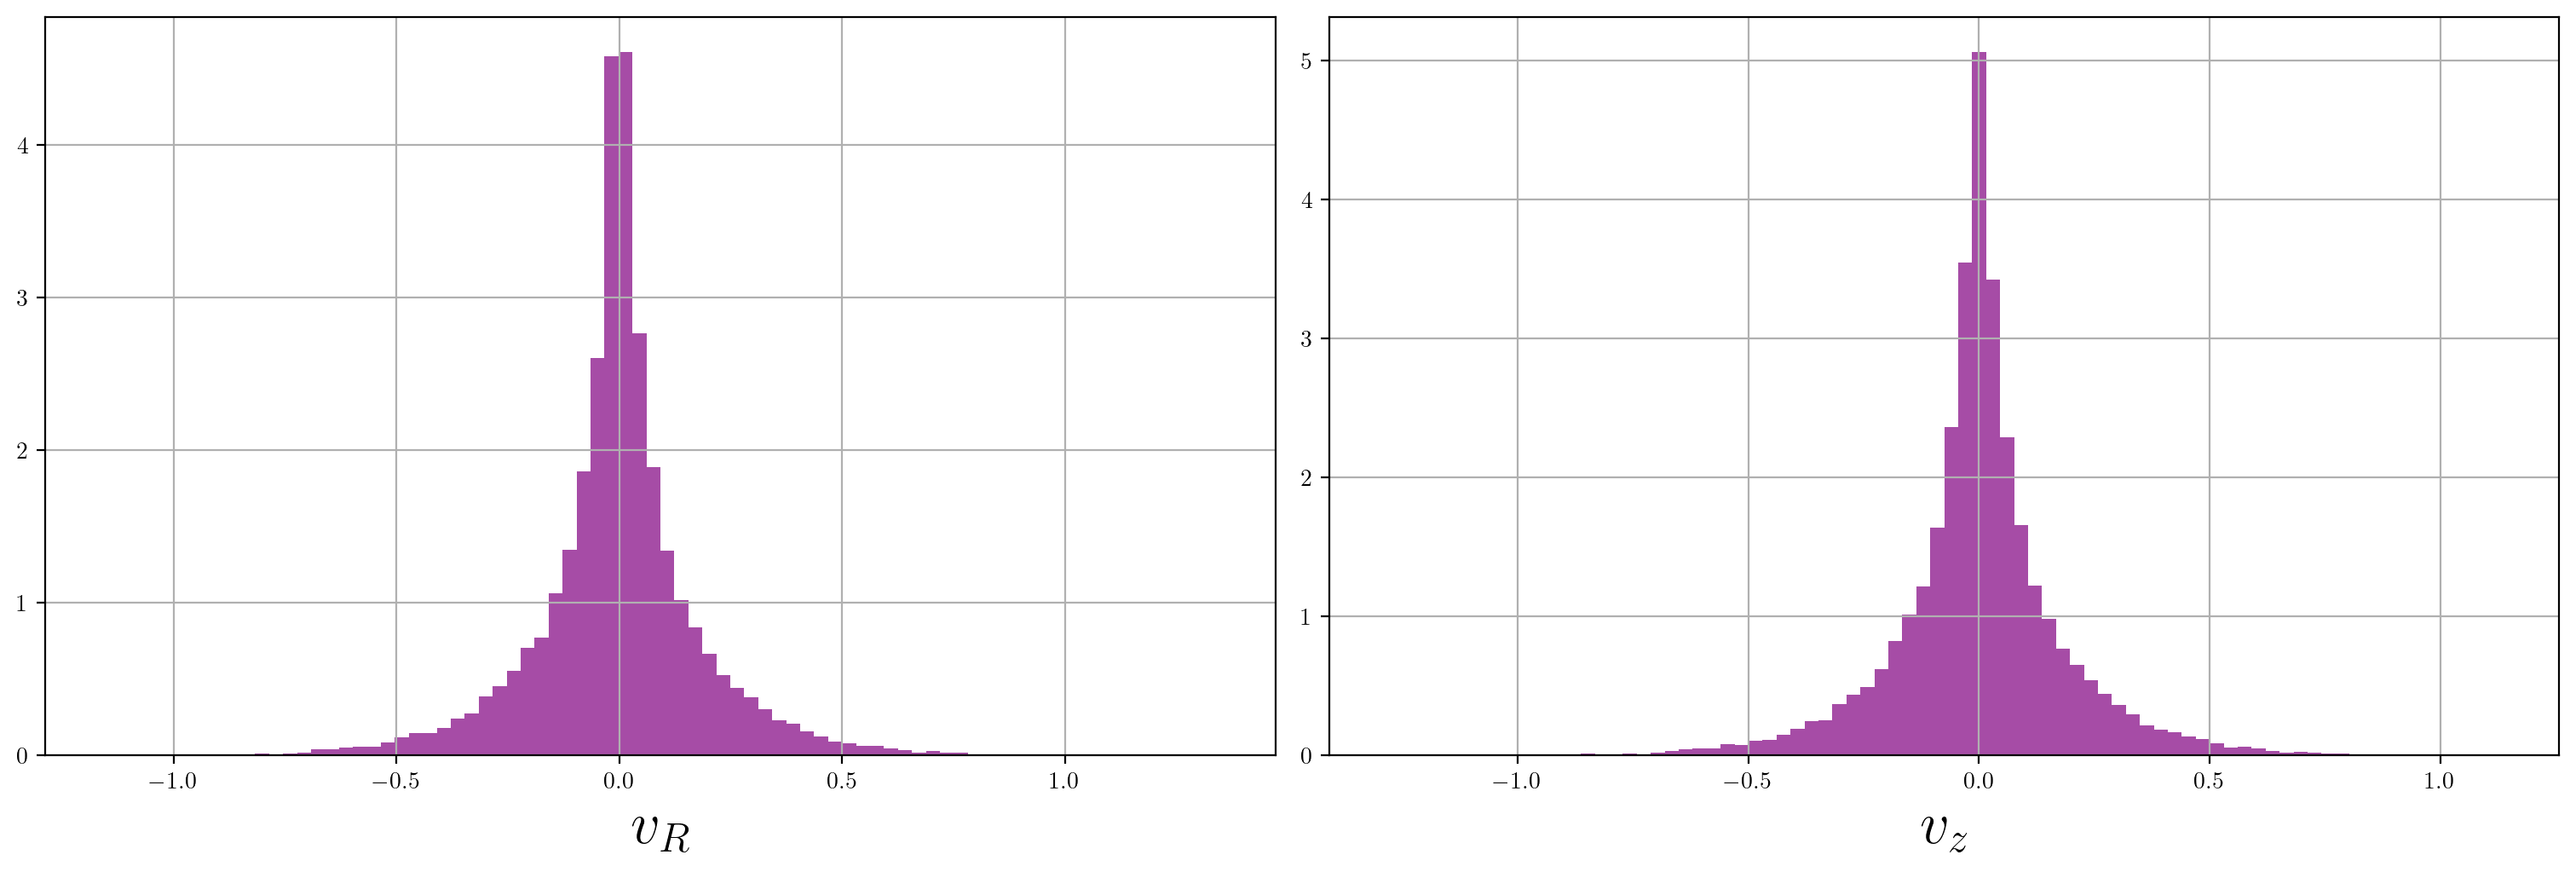

In [21]:
# Velovcities histograms
fig, axes = plt.subplots(1, 2, figsize=(15, 5), constrained_layout=True)

axes[0].hist(v_r, bins=80, color='purple', alpha=0.7, density=True)
axes[0].set_xlabel(r"$v_R$", fontsize=25)
axes[0].grid(True)

axes[1].hist(v_z, bins=80, color='purple', alpha=0.7, density=True)
axes[1].set_xlabel(r"$v_z$", fontsize=25)
axes[1].grid(True)

plt.savefig('vx_vz.png')
plt.show()

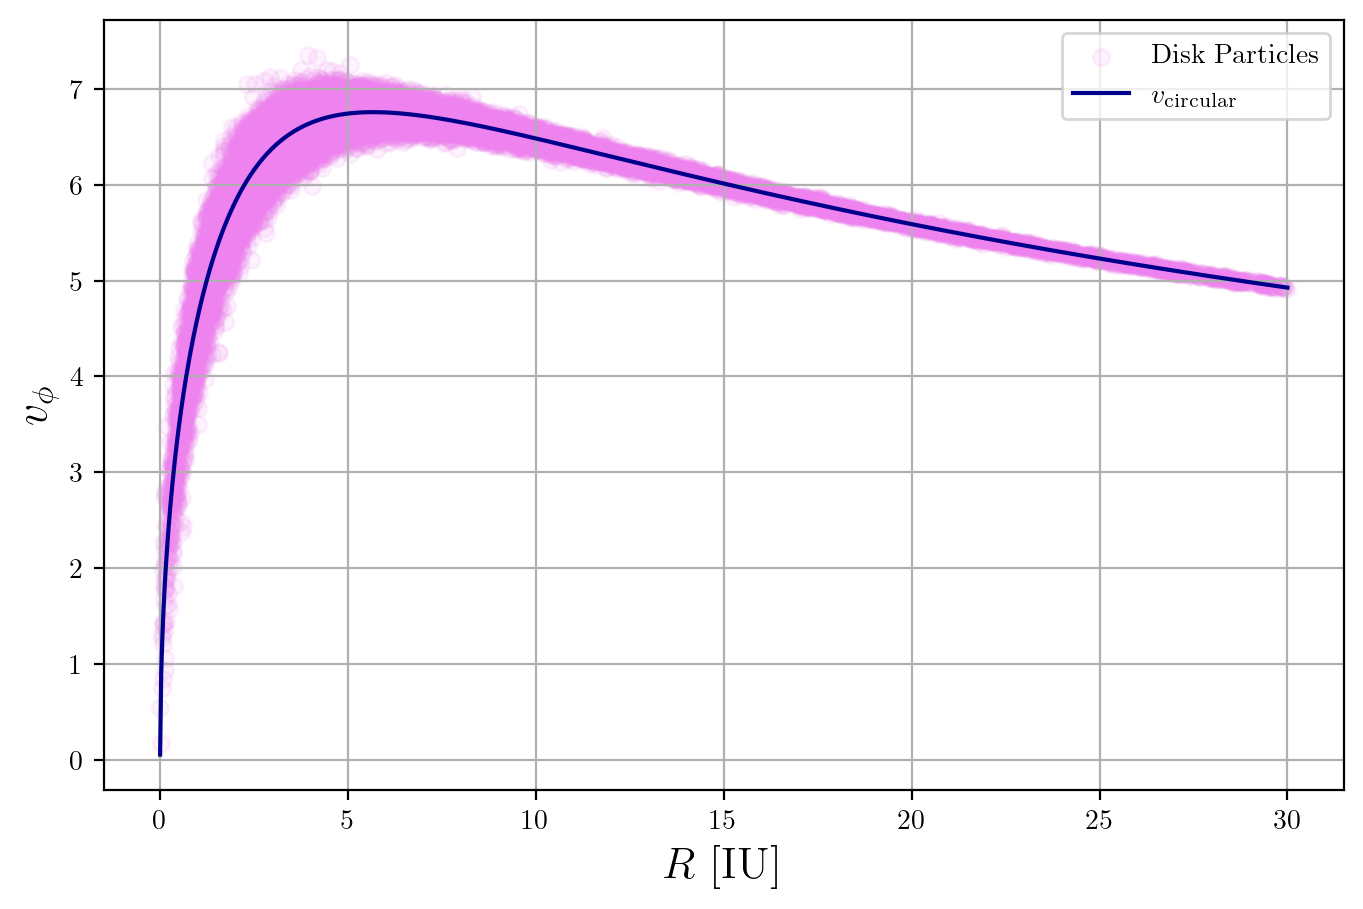

In [130]:
R_grid = np.linspace(0.0001,30,1000)
v_phi_teo = v_circ(R_grid)
plt.figure(figsize=(8,5))
plt.scatter(R_tot, v_phi, alpha=0.1, color='violet', label='Disk Particles')

#theorical circular velocity
plt.plot(R_grid, v_phi_teo, color='darkblue', label='$v_{\mathrm{circular}}$')

plt.xlabel('$R$ [IU]', fontsize=16)
plt.ylabel('$v_{\phi}$', fontsize=16)

plt.legend(fontsize=10)
plt.grid()

plt.savefig('v_phi_distr.png')
plt.show()

### Treecode parameters

In [131]:
m_pert=m_particles*500

In [132]:
m_pert

0.856878796401666

In [142]:
M_D/m_pert

40.00000000000001

In [133]:
x_tot.shape

(20001,)

In [150]:
#volume = np.pi * a**2 * (np.max(z_particles)*2)
volume = (M_D+m_pert)  / np.max(rho_D(np.array(R_tot), np.array(z_tot)))
softening = ((volume/num_particles)**(1/3))

print(f'Softening parameter = {softening:.3f}')

Softening parameter = 0.095


In [151]:
def calculate_accelerations(R, z):
    # Potenziale dell'alone
    denominator_halo = (R**2 + z**2 + softening**2)**1.5
    acc_R_halo = -G * M_H * R / denominator_halo
    acc_z_halo = -G * M_H * z / denominator_halo

    # Potenziale del disco
    sqrt_zb2 = np.sqrt(z**2 + b**2)
    denominator_disk = ((a + sqrt_zb2)**2 + R**2)**1.5
    acc_R_disk = -G * M_D * R / denominator_disk
    acc_z_disk = -G * M_D * z * (a + sqrt_zb2) / (sqrt_zb2 * denominator_disk)

    # Accelerazioni totali
    acc_R_total = acc_R_halo + acc_R_disk
    acc_z_total = acc_z_halo + acc_z_disk
    return acc_R_total, acc_z_total

# Calcolo delle accelerazioni
acc_R, acc_z = calculate_accelerations(np.array(R_tot), np.array(z_tot))

# Modulo dell'accelerazione totale per ogni particella
acc_total = np.sqrt(acc_R**2 + acc_z**2)

# Accelerazione massima
acc_max = np.max(acc_total)

print(f"L'accelerazione massima è: {acc_max:.5e}")

L'accelerazione massima è: 4.17693e+04


In [152]:
dt = 0.5 * np.sqrt(softening / acc_max)
print('Timestep:', dt)

Timestep: 0.0007539262017918349


In [153]:
rho_mean = np.mean(rho_D(np.array(R_tot), np.array(z_tot)))
t_dyn = np.sqrt(1/rho_mean)

print(f'Dynamical timescale = {t_dyn}')

Dynamical timescale = 1.8810655297313683


In [154]:
M_D

34.27515185606664

In [141]:
# ./treecode in=../treecode_in_perturber.txt out=../treecode_out_perturber.txt dtime=0.00077 eps=0.096 theta=0.2 tstop=22.8 dtout=0.47 > ../output_treecode_perturber.txt